In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster



# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

(1000, 200, 3)
(1000, 200, 3)
652.7005


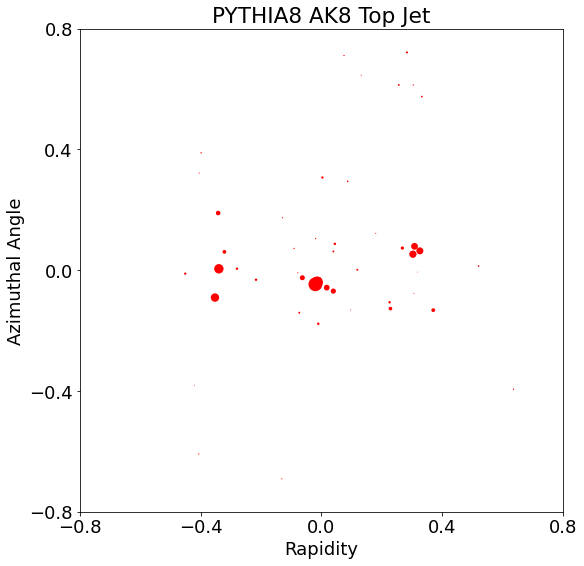

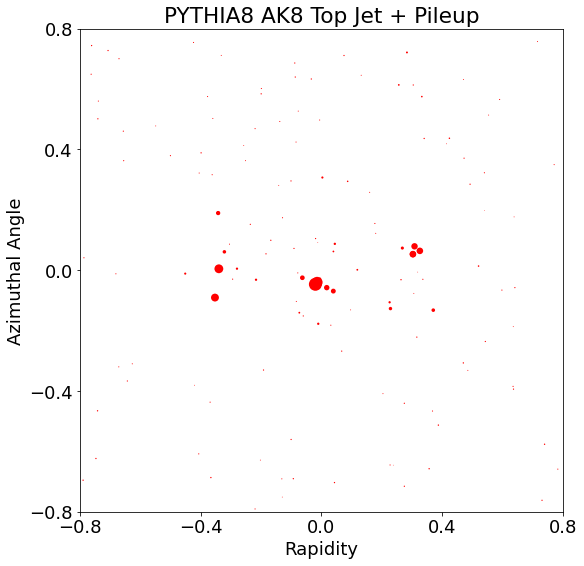

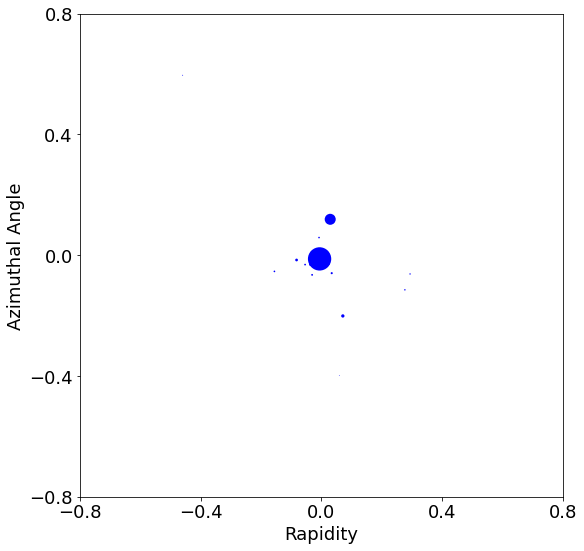

172.6280110817225 22.275782673483835
0.3706340030922258 0.04395483264080654


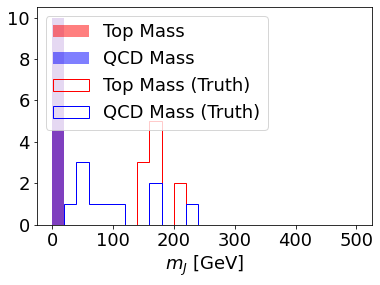

(array([1., 1., 0., 0., 0., 1., 1., 3., 2., 1.]),
 array([-217.33033465, -210.08824885, -202.84616306, -195.60407726,
        -188.36199147, -181.11990567, -173.87781988, -166.63573408,
        -159.39364829, -152.15156249, -144.9094767 ]),
 <BarContainer object of 10 artists>)

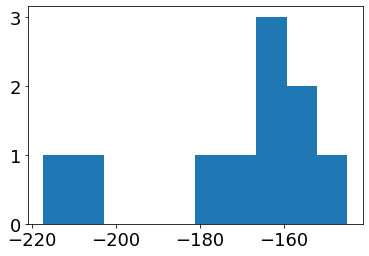

In [2]:
# Parameters
R = 0.8
beta = 1
N = 10

mass_lower = 0
mass_upper = np.inf
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"


# cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
# sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
# print(cms_weights.shape)
# events = (cms, sim)


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)


# Add pileup
signal_pu = normalize_events(add_pileup(signal, 100, 50, 250, 25, R))
background_pu = normalize_events(add_pileup(background, 100, 50, 250, 25, R))
signal_pu_mass = calculate_masses(signal_pu)
background_pu_mass = calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

print(np.mean(signal_mass), np.std(signal_mass))
print(np.mean(signal_pu_mass), np.std(signal_pu_mass))


plt.hist(signal_pu_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(background_pu_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(signal_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass (Truth)", alpha = 1.0, histtype="step")
plt.hist(background_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass (Truth)", alpha = 1.0, histtype="step")
plt.legend(loc = "upper left")
plt.xlabel(r"$m_J$ [GeV]")
plt.show()


plt.hist(signal_pu_mass - signal_mass)



In [3]:


emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))




In [4]:


from random import sample


ns = [1, 2, 4, 8, 16, 32]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]


def calculate_isotropy(beta, dataset, directory):

        emds_pot = np.zeros((len(ns), N))
        emds_sinkhorn = np.zeros((len(epsilons), len(ns), N))
        times_sinkhorn = np.zeros((len(epsilons), len(ns)))

        ###############
        ##### POT #####
        ###############

        for (i, n) in enumerate(ns):

                points, zs = [], []
                for y in np.linspace(-R,R, n):
                        for phi in np.linspace(-R, R, n):

                                points.append((y, phi))
                                zs.append(1.0 / (n**2))


                refernce_event = (np.array(points), np.array(zs))

                def _cdist_phi_y(X,Y, ym):
                        # define ym as the maximum rapidity cut on the quasi-isotropic event
                        # Make sure the phi values are in range                                                                                                                                          
                        phi1 = (X[:,1])
                        phi2 = (Y[:,1])
                        # Trick to account for phi distance periodicity
                        phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
                        # norm = 12.0/(np.pi*np.pi+16*ym*ym)
                        norm = 1
                        y_d = X[:,0,np.newaxis] - Y[:,0]
                        dist =(phi_d**2 + y_d**2)
                        dist = np.power(dist, beta / 2)
                        return dist

                # Calculate the EMDs for each observable, for each event
                for (k, event) in enumerate(dataset):

                        t1 = time()
                        xi, ai = event
                        yj, bj = refernce_event
                        M = _cdist_phi_y(xi, yj, R)
                        ai = ai.astype(np.float64) 
                        ai = (ai / ai.sum().astype(np.float64)).astype(np.float64)
                        emd_val, log = emd2(ai, bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
                        # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
                        if emd_val==0:
                                print(log['warning'])
                        emds_pot[i,k] = emd_val
                        t2 = time()


                print(np.mean(emds_pot[i]))





        # ####################
        # ##### SINKHORN #####
        # ####################

        observables = {}


        def build_reference_event(n):
                points, zs = [], []
                for y in np.linspace(-R,R, n):
                        for phi in np.linspace(-R, R, n):

                                points.append((y, phi))
                                zs.append(1.0 / (n**2))

                refernce_event = (np.array(points), np.array(zs))
                return refernce_event


        def isotropy_samples(n, param_dict, refernce_event, dtype=torch.FloatTensor):

                zs = torch.from_numpy(refernce_event[1]).type(dtype)
                points = torch.from_numpy(refernce_event[0]).type(dtype)
                return (points, zs)

        ref1 = build_reference_event(1)
        ref2 = build_reference_event(2)
        ref4 = build_reference_event(4)
        ref8 = build_reference_event(8)
        ref16 = build_reference_event(16)
        ref32 = build_reference_event(32)

        samples1 = lambda n, param_dict: isotropy_samples(n, param_dict, ref1)
        samples2 = lambda n, param_dict: isotropy_samples(n, param_dict, ref2)
        samples4 = lambda n, param_dict: isotropy_samples(n, param_dict, ref4)
        samples8 = lambda n, param_dict: isotropy_samples(n, param_dict, ref8)
        samples16 = lambda n, param_dict: isotropy_samples(n, param_dict, ref16)
        samples32 = lambda n, param_dict: isotropy_samples(n, param_dict, ref32)

        _isotropy1 = Observable({}, samples1, beta = beta, R = R)
        _isotropy2 = Observable({}, samples2, beta = beta, R = R)
        _isotropy4 = Observable({}, samples4, beta = beta, R = R)
        _isotropy8 = Observable({}, samples8, beta = beta, R = R)
        _isotropy16 = Observable({}, samples16, beta = beta, R = R)
        _isotropy32 = Observable({}, samples32, beta = beta, R = R)


        observables["Isotropy_1"] = _isotropy1
        observables["Isotropy_2"] = _isotropy2
        observables["Isotropy_4"] = _isotropy4
        observables["Isotropy_8"] = _isotropy8
        observables["Isotropy_16"] = _isotropy16
        observables["Isotropy_32"] = _isotropy32



        shaper = Shaper(observables, device)
        shaper.to(device)

        emds = []
        times = []
        for (e,epsilon) in enumerate(epsilons):


                print(epsilon)

                shapers = []

                for (i, n) in enumerate(ns):

                        t1 = time()

                        shaper = Shaper({"Isotropy_%d" % n : observables["Isotropy_%d" % n]}, device)
                        shaper.to(device)
                        shapers.append(shaper)
                        signal_emds, signal_params = shaper.calculate(dataset, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = epsilon, early_stopping= 25, N = 500)


                        emds_sinkhorn[e,i] = signal_emds["Isotropy_%d" % n]
                        times_sinkhorn[e,i] = time() - t1

        np.save("%s_isotropy_emds_sinkhorn.npy" % directory, emds_sinkhorn)
        np.save("%s_isotropy_times_sinkhorn.npy" % directory, times_sinkhorn)

        np.save("%s_isotropy_emds_pot.npy" % directory, emds_pot)

# calculate_isotropy(1, signal_pu, "data/signal_pu_1")
# calculate_isotropy(2, signal_pu, "data/signal_pu_2")

# calculate_isotropy(1, background_pu, "data/background_pu_1")
# calculate_isotropy(2, background_pu, "data/background_pu_2")

In [5]:
from NSubjettiness import model, Graph
import torch.optim as optim


# 1, 2, and 3 Subjettiness
Rprime = np.inf
subjet1 = Graph.graph([[1]], R, Rprime)
subjet2 = Graph.graph([[1], [2]], R, Rprime)
subjet3 = Graph.graph([[1], [2], [3]], R, Rprime)


Ns = [1, 2, 3]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

def calculate_nsubjettiness(dataset, directory):


    emds_kds = np.zeros((len(Ns), N))
    emds_sinkhorn = np.zeros((len(epsilons), len(Ns), min(N, len(dataset))))
    times_sinkhorn = np.zeros((len(epsilons), len(Ns)))

    # N subjettiness:
    for (index, x) in enumerate(dataset):

        yphi, z = x[0], x[1]
        
        # kT clustering
        four_vectors = []
        for (e, p) in zip(z, yphi):
            v = (e, p[0], p[1], 0)
            four_vectors.append(v)
        four_vectors = np.array(four_vectors, dtype = [("pt", "f8"),("eta", "f8"),("phi", "f8"),("mass", "f8")])
        sequence = cluster(four_vectors, R=R, p=1)
        jets_ = sequence.inclusive_jets()

        def n_subjettiness(n):
            jets =  sequence.exclusive_jets(n)
            ys = []
            zs = []
            for jet in jets:
                ys.append([jet.eta, jet.phi])
                zs.append(jet.pt)
            ys = np.array(ys)

            diffs = yphi[:,None, :] - ys[None, :, :]
            rs = np.sqrt(np.sum(np.square(diffs), axis = 2))
            min_rs = np.amin(rs, axis = 1)
            return np.sum(z * min_rs)

        # def train(graph, data, labels):


        #     # Initialize model
        #     hyp = {
        #     "num_layers": 15,
        #     "input_size": 2,
        #     "R": Rprime,
        #     "Rprime": R,
        #     "train_step": True,
        #     "weighted": True
        #     }

        #     hyp['hidden_size'] = graph.num_anchors
        #     hyp['graph'] = graph

        #     lr = 1e-2
        #     epochs = 1000
        #     early_stopping = 25
        #     batch_size = 10000
        #     workers = 4
        #     seed = 0
        #     counter = 0
        #     min_loss = np.inf

        #     net = model.KDS(**hyp)
        #     with torch.no_grad():
        #         jets_ = sequence.exclusive_jets(net.hidden_size)
        #         initialization = []
        #         for jet in jets_:
        #             initialization.append([jet.phi, jet.eta])
        #         initialization = np.array(initialization).astype(np.float32)
        #         # if (initialization.shape[0] < net.hidden_size):
        #         #     p = torch.randperm(len(z))[: net.hidden_size - initialization.shape[0]]
        #         #     initialization = torch.cat((torch.tensor(initialization), torch.tensor(yphi[p])))
        #         # else:
        #         initialization = torch.tensor(initialization[:net.hidden_size])

        #         net.W.data = torch.clone(initialization)
        #         net.step.fill_((net.W.data.svd()[1][0] ** -2).item())
        #     net = net.to(device)

        #     # Optimizer and loss function
        #     optimizer = optim.Adam(net.parameters(), lr=lr)
        #     criterion = model.LocalDictionaryLoss(net.loss)

        #     # Train
        #     net.train()

        #     shuffle = torch.randperm(len(z))
        #     data_shuffled, labels_shuffled = yphi[shuffle], z[shuffle]
        #     for i in range(0, len(z), batch_size):
        #         y = torch.Tensor(data_shuffled[i: i + batch_size]).to(device)
        #         l = torch.Tensor(labels_shuffled[i: i + batch_size]).to(device)
        #         yhat, x_hat, x0 = net.encode(y)
        #         if hyp["weighted"]:
        #             loss = criterion(net.W, y, x_hat, x0, w=l)
        #         else:
        #             loss = criterion(net.W, y, x_hat, x0)

        #     for epoch in range(epochs):
        #         shuffle = torch.randperm(len(z))
        #         data_shuffled, labels_shuffled = yphi[shuffle], z[shuffle]
        #         for i in range(0, len(z), batch_size):
        #             y = torch.Tensor(data_shuffled[i: i + batch_size]).to(device)
        #             l = torch.Tensor(labels_shuffled[i: i + batch_size]).to(device)
        #             yhat, x_hat, x0 = net.encode(y)
        #             if hyp["weighted"]:
        #                 loss = criterion(net.W, y, x_hat, x0, w=l)
        #             else:
        #                 loss = criterion(net.W, y, x_hat, x0)
        #             optimizer.zero_grad()
        #             loss.backward()
        #             nn.utils.clip_grad_norm_(net.parameters(), 1e-4)
        #             optimizer.step()
        #             # net.W.data = torch.tensor([[1.0, -1.0],])

        #         if loss.item() < min_loss:
        #             min_loss = loss.cpu().detach().numpy()
        #             counter = 0
        #         else:
        #             counter += 1

        #         if counter > early_stopping:
        #             break

        #     return min_loss

        emds_kds[0, index] = n_subjettiness(1) 
        emds_kds[1, index] = n_subjettiness(2) 
        emds_kds[2, index] = n_subjettiness(3) 

        print(emds_kds[2, index] / emds_kds[1, index])

    

    # # SINKHORN 

    # observables = {}
    # # Sample at N weighted Dirac deltas
    # def point_sampler(N, param_dict):
    #     return (param_dict["Points"].params, param_dict["Weights"].params)

    # for n in Ns:

    #     _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    #     observables["%d-Subjettiness" % n] = _nsubjettiness

    # shapers = []
    # for (e, epsilon) in enumerate(epsilons):
    #     for (i, n) in enumerate(Ns):

    #         t1 = time()

    #         shaper = Shaper({"%d-Subjettiness" % n : observables["%d-Subjettiness" % n]}, device)
    #         shaper.to(device)
    #         shapers.append(shaper)
    #         signal_emds, signal_params = shaper.calculate(dataset, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = epsilon, early_stopping= 25, N = 500)


    #         emds_sinkhorn[e,i] = signal_emds["%d-Subjettiness" % n]
    #         times_sinkhorn[e,i] = time() - t1

    #     print(emds_sinkhorn[e,2])

    # np.save("%s_nsubjettiness_emds_sinkhorn.npy" % directory, emds_sinkhorn)
    # np.save("%s_nsubjettiness_times_sinkhorn.npy" % directory, times_sinkhorn)
    # np.save("%s_nsubjettiness_emds_pot.npy" % directory, emds_kds)


# calculate_nsubjettiness(signal_pu, "data/signal_pu")
# calculate_nsubjettiness(background_pu, "data/background_pu")


In [6]:

# np.save("emds_sinkhorn_%d.npy" % beta, emds_sinkhorn)
# np.save("times_sinkhorn_%d.npy" % beta, times_sinkhorn)

# np.save("emds_pot_%d.npy" % beta, emds_pot)






[0.5486836433410645, 1.2726845741271973, 6.654840469360352]
[0.4855966567993164, 1.1401286125183105, 5.635168790817261]
[0.4209861755371094, 0.8460609912872314, 4.7399210929870605]
[0.36026620864868164, 0.6940579414367676, 3.6553401947021484]
[0.29676365852355957, 0.5331881046295166, 2.7662465572357178]
[0.34247827529907227, 0.3755812644958496, 1.6242237091064453]


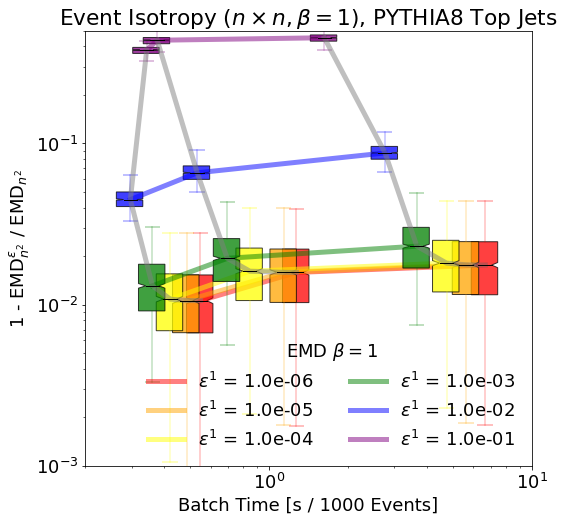

[0.35883021354675293, 0.8029773235321045, 3.6443839073181152]
[0.32792019844055176, 0.6118733882904053, 3.2536773681640625]
[0.2950103282928467, 0.5322122573852539, 2.7607858180999756]
[0.26275086402893066, 0.563798189163208, 2.125488519668579]
[0.23121213912963867, 0.4840226173400879, 1.615934133529663]
[0.20019054412841797, 0.29302191734313965, 1.2296149730682373]


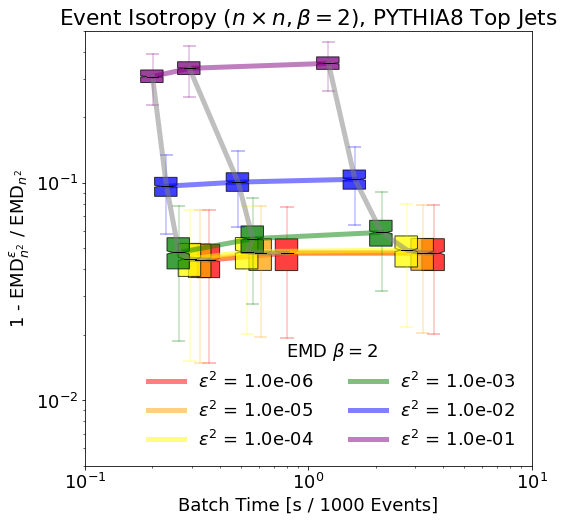

In [7]:
ns = [1, 2, 4, 8, 16, 32]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

def plot_times(dataset, beta, xlim, ylim):

    emds_sinkhorn = np.load("data/%s_%d_isotropy_emds_sinkhorn.npy" % (dataset, beta))
    times_sinkhorn = np.load("data/%s_%d_isotropy_times_sinkhorn.npy" % (dataset, beta))
    emds_pot = np.load("data/%s_%d_isotropy_emds_pot.npy" % (dataset, beta))

    accuracies = beta * emds_sinkhorn / emds_pot[None,:,:] * (R**beta)

    accuracies = accuracies[:,3:,:]
    times_sinkhorn = times_sinkhorn[:,3:]



    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]

    w = 0.1
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


    for (e, eps) in enumerate(epsilons):

        print(times_sinkhorn[e].tolist())
        bp = ax.boxplot((1-accuracies[e]).tolist(), positions = times_sinkhorn[e], showfliers=False, patch_artist = True, notch=True, widths=width(times_sinkhorn[e],w),)

        for i,patch in enumerate(bp['boxes']):
            patch.set(color = colors[e], alpha = 0.75, edgecolor= "black")

        for whisker in bp['whiskers']:
            whisker.set(color =colors[e],
                        linewidth = 1.5,
                        alpha = 0.25,
                        )
        
        # changing color and linewidth of
        # caps
        for cap in bp['caps']:
            cap.set(color = colors[e],
                    linewidth = 2,
                    alpha = 0.25,
                    )
        
        # changing color and linewidth of
        # medians
        for median in bp['medians']:
            median.set(color = "black",
                    linewidth = 1)


        average = np.median(1-accuracies[e], axis = 1)
        plt.plot(times_sinkhorn[e], average, color = colors[e],label = "$\epsilon^{%d}$ = %.1e" % (beta,eps), alpha = 0.5, linewidth = 5)
        # plt.axhline(np.sqrt(epsilons[e]), color = colors[e], label = "$\epsilon^2$ = %.1e" % eps, linewidth = 10, alpha = 0.10)


    for (i, n) in enumerate(ns[3:]):
        average = np.median(1-accuracies[:,i,:], axis = 1)
        plt.plot(times_sinkhorn[:,i], average, color = "gray", alpha = 0.5, linewidth = 5)


        # plt.boxplot(accuracies[e].tolist(), positions=times_sinkhorn[e].tolist())

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Batch Time [s / 1000 Events]")
    plt.ylabel("1 - EMD$^\epsilon_{n^2}$ / EMD$_{n^2}$")
    plt.title(r"Event Isotropy $(n \times n, \beta = %d)$, PYTHIA8 Top Jets" % beta)
    plt.legend(title = r"EMD $\beta = %d$" % beta, loc = "lower right", ncol = 2, frameon = False)
    # plt.ylabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
    # plt.show()
    plt.savefig("Plots/isotropy_%d.pdf" % beta)
    plt.show()

plot_times("signal_pu", 1, (2e-1, 1e1), (1e-3, 5e-1))
plot_times("signal_pu", 2, (1e-1, 1e1), (5e-3, 5e-1))


# plot_times("signal_pu", 1, (1e-0, 1e3), (1e-4, 5e-1))
# plot_times("signal_pu", 2, (1e-0, 5e2), (1e-3, 5e-1))


[343.52368330955505, 446.1191568374634, 459.06246972084045]
[243.65551662445068, 341.514034986496, 363.9695520401001]
[153.05347275733948, 239.41155767440796, 263.78170680999756]
[133.241126537323, 427.8375744819641, 498.9004154205322]
[113.05080509185791, 144.54094290733337, 183.5712993144989]
[55.502049922943115, 70.78598976135254, 81.11367964744568]


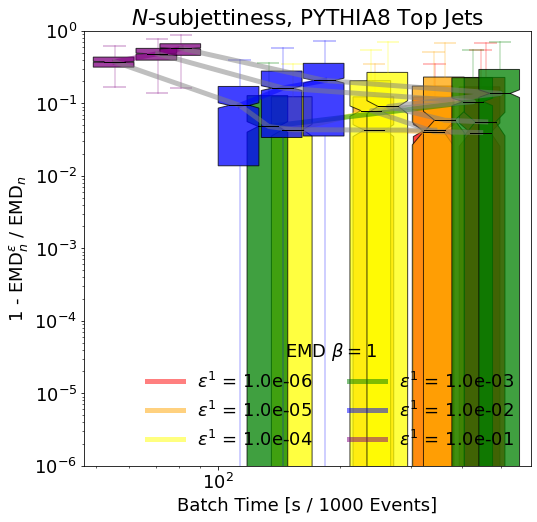

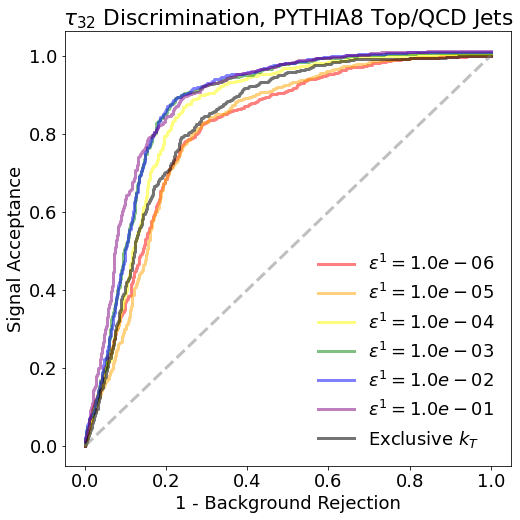

In [8]:
# ROC Curves for tau_32
from sklearn.metrics import roc_curve, auc


ns  = [1,2,3]
def plot_times(xlim, ylim):

    dataset = "signal_pu"

    emds_sinkhorn = np.load("data/%s_nsubjettiness_emds_sinkhorn.npy" % (dataset))
    times_sinkhorn = np.load("data/%s_nsubjettiness_times_sinkhorn.npy" % (dataset))
    emds_pot = np.load("data/%s_nsubjettiness_emds_pot.npy" % dataset)

    accuracies = beta * emds_sinkhorn / emds_pot[None,:,:] * (R**beta)

    accuracies = accuracies[:,:,:]
    times_sinkhorn = times_sinkhorn[:,:]



    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]

    w = 0.1
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)


    for (e, eps) in enumerate(epsilons):

        print(times_sinkhorn[e].tolist())
        bp = ax.boxplot((1-accuracies[e]).tolist(), positions = times_sinkhorn[e], showfliers=False, patch_artist = True, notch=True, widths=width(times_sinkhorn[e],w),)

        for i,patch in enumerate(bp['boxes']):
            patch.set(color = colors[e], alpha = 0.75, edgecolor= "black")

        for whisker in bp['whiskers']:
            whisker.set(color =colors[e],
                        linewidth = 1.5,
                        alpha = 0.25,
                        )
        
        # changing color and linewidth of
        # caps
        for cap in bp['caps']:
            cap.set(color = colors[e],
                    linewidth = 2,
                    alpha = 0.25,
                    )
        
        # changing color and linewidth of
        # medians
        for median in bp['medians']:
            median.set(color = "black",
                    linewidth = 1)


        average = np.median(1-accuracies[e], axis = 1)
        plt.plot(times_sinkhorn[e], average, color = colors[e],label = "$\epsilon^{%d}$ = %.1e" % (beta,eps), alpha = 0.5, linewidth = 5)
        # plt.axhline(np.sqrt(epsilons[e]), color = colors[e], label = "$\epsilon^2$ = %.1e" % eps, linewidth = 10, alpha = 0.10)


    for (i, n) in enumerate(ns[:]):
        average = np.median(1-accuracies[:,i,:], axis = 1)
        plt.plot(times_sinkhorn[:,i], average, color = "gray", alpha = 0.5, linewidth = 5)


        # plt.boxplot(accuracies[e].tolist(), positions=times_sinkhorn[e].tolist())

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(ylim)
    # plt.xlim(xlim)
    plt.xlabel("Batch Time [s / 1000 Events]")
    plt.ylabel("1 - EMD$^\epsilon_{n}$ / EMD$_{n}$")
    plt.title(r"$N$-subjettiness, PYTHIA8 Top Jets")
    plt.legend(title = r"EMD $\beta = %d$" % beta, loc = "lower right", ncol = 2, frameon = False)
    # plt.ylabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
    # plt.show()
    plt.savefig("Plots/nsubjettiness_times.pdf")
    plt.show()


def ROC():

    signal_emds_sinkhorn = np.load("data/signal_pu_nsubjettiness_emds_sinkhorn.npy")
    signal_emds_pot = np.load("data/signal_pu_nsubjettiness_emds_pot.npy")


    background_emds_sinkhorn = np.load("data/background_pu_nsubjettiness_emds_sinkhorn.npy")
    background_emds_pot = np.load("data/background_pu_nsubjettiness_emds_pot.npy")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]

    for (e, eps) in enumerate(epsilons):

        signal_tau_sinkhorn = signal_emds_sinkhorn[e, 2, :] / signal_emds_sinkhorn[e, 1, :]
        background_tau_sinkhorn = background_emds_sinkhorn[e, 2, :] / background_emds_sinkhorn[e, 1, :]

        labels = np.concatenate((np.zeros((signal_tau_sinkhorn.shape[0],)), np.ones((background_tau_sinkhorn.shape[0],))))
        y_= np.concatenate((signal_tau_sinkhorn, background_tau_sinkhorn))

        fpr, tpr, _ = roc_curve(labels, y_)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr + 0.0025*e, color = colors[e], alpha = 0.5, label = r"$\epsilon^1 = %.1e$" % (eps), lw = 3)

    signal_tau_pot = signal_emds_pot[2, :] / signal_emds_pot[1, :]
    background_tau_pot = background_emds_pot[2, :] / background_emds_pot[1, :]
    labels = np.concatenate((np.zeros((signal_tau_pot.shape[0],)), np.ones((background_tau_pot.shape[0],))))
    y_= np.concatenate((signal_tau_pot, background_tau_pot))
    fpr, tpr, _ = roc_curve(labels, y_)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color = "black", alpha = 0.55, label = r"Exclusive $k_T$", lw = 3)
    plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), color = "grey", alpha = 0.5, ls = "--", lw = 3)
    plt.title("$\\tau_{32}$ Discrimination, PYTHIA8 Top/QCD Jets")
    plt.ylabel("Signal Acceptance")
    plt.xlabel("1 - Background Rejection")
    plt.legend(frameon = False)
    plt.savefig("roc_benchmarks.pdf")
    plt.show()
    plt.close()

    # plt.hist(signal_tau_pot)
    # plt.hist(signal_tau_pot)


    

plot_times([1e-1, 1e1], [1e-6, 1e0])
ROC()    # accuracies = beta * emds_sinkhorn / emds_pot[None,:,:] * (R**beta)
    

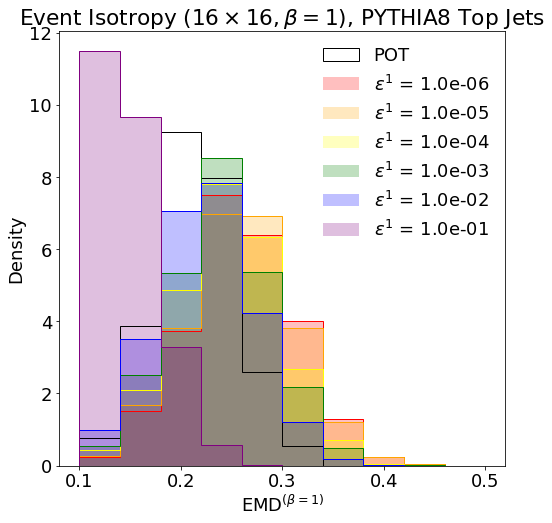

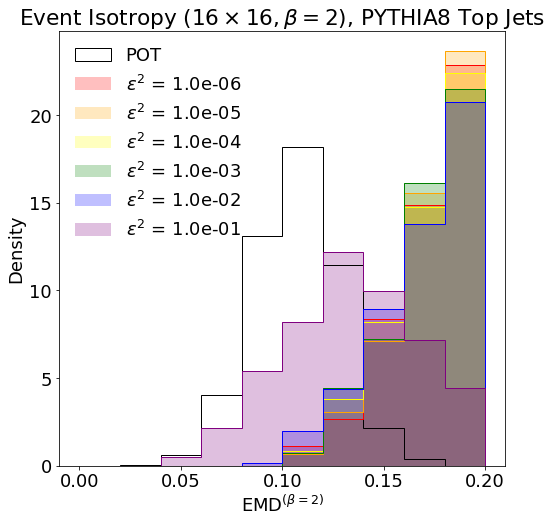

In [9]:
# Plot absolute distributions:

def absolute_hist(beta, lims):

    dataset = "signal_pu"

    emds_sinkhorn = np.load("data/%s_nsubjettiness_emds_sinkhorn.npy" % (dataset))
    times_sinkhorn = np.load("data/%s_nsubjettiness_times_sinkhorn.npy" % (dataset))
    emds_pot = np.load("data/%s_nsubjettiness_emds_pot.npy" % (dataset))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    
    
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]
    bins = 10
    
    plt.hist(emds_pot[-2] / beta, bins = bins, range = lims, density= True, label = "POT", color = "black", histtype="step")
    for (e, eps) in enumerate(epsilons):
        plt.hist(emds_sinkhorn[e,-2], bins = bins, range = lims, density= True, color = colors[e], histtype="step")
        plt.hist(emds_sinkhorn[e,-2], bins = bins, range = lims, density= True, label = "$\epsilon^{%d}$ = %.1e" % (beta,eps), color = colors[e], alpha = 0.25)

    plt.xlabel(r"EMD$^{(\beta  = %d)}$" % beta)
    plt.ylabel("Density")
    plt.title(r"Event Isotropy $(16\times 16, \beta = %d)$, PYTHIA8 Top Jets" % beta)
    plt.legend(frameon = False)
    plt.savefig("Plots/isotropy_hist_%d.pdf" % beta)
    plt.show()
    plt.close()


    # ROC curve
    

absolute_hist(1, (0.1, 0.5))
absolute_hist(2, (0.0, 0.2))

In [10]:
# plt.hist(signal_emds["2 Subjettiness"] / signal_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["2 Subjettiness"] / background_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()
# plt.show()

# plt.hist(signal_emds["3 Subjettiness"] / signal_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
# plt.hist(background_emds["3 Subjettiness"] / background_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
# plt.legend()

# Becnhmarks - Gradients

In [11]:

# Define N-Subjettiness
Ns = np.arange(1,4)
observables = {}

# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

for n in Ns:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

# Define Isotropy
def build_reference_event(n):
    points, zs = [], []
    for y in np.linspace(-R,R, n):
            for phi in np.linspace(-R, R, n):

                    points.append((y, phi))
                    zs.append(1.0 / (n**2))

    refernce_event = (np.array(points), np.array(zs))
    return refernce_event

reference_event = build_reference_event(16)

def isotropy_samples(n, param_dict, dtype=torch.FloatTensor):

        zs = torch.from_numpy(reference_event[1]).type(dtype)
        points = torch.from_numpy(reference_event[0]).type(dtype)
        return (points, zs)

observables["Isotropy"] = Observable({}, isotropy_samples, beta = 1, R = 0.8) 

shaper = Shaper(observables, device)
shaper.to(device)
signal_emds, signal_params, Fs, dxs = shaper.calculate(signal_pu, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=True)
background_emds, background_params, _, _ = shaper.calculate(background_pu, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=True)


Observable: 1-Subjettiness Epoch 0 Mean Loss = 0.3662223696708679 Elapsed time = 0.292s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 1 Mean Loss = 0.36322484612464906 Elapsed time = 0.551s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 2 Mean Loss = 0.360765215754509 Elapsed time = 0.773s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 3 Mean Loss = 0.3589836537837982 Elapsed time = 1.023s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 4 Mean Loss = 0.3576096683740616 Elapsed time = 1.351s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 5 Mean Loss = 0.35671457946300505 Elapsed time = 1.580s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 6 Mean Loss = 0.3562862664461136 Elapsed time = 1.819s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 7 Mean Loss = 0.3556948721408844 Elapsed time = 2.047s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 8 Mean Loss = 0.35550543665885925 Elapsed time = 2.268s Percen

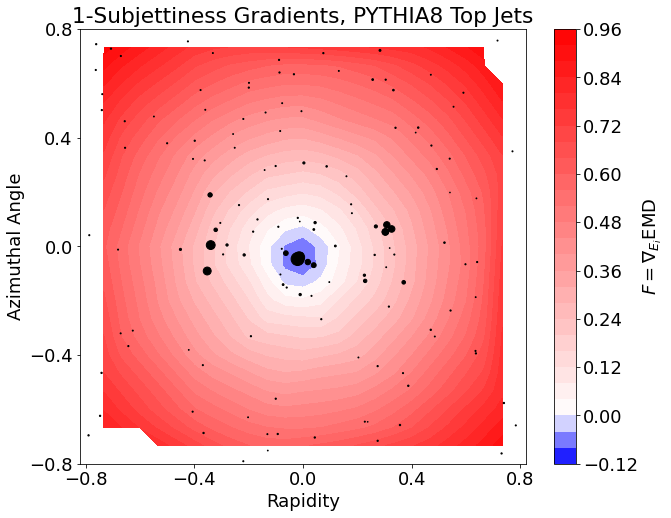

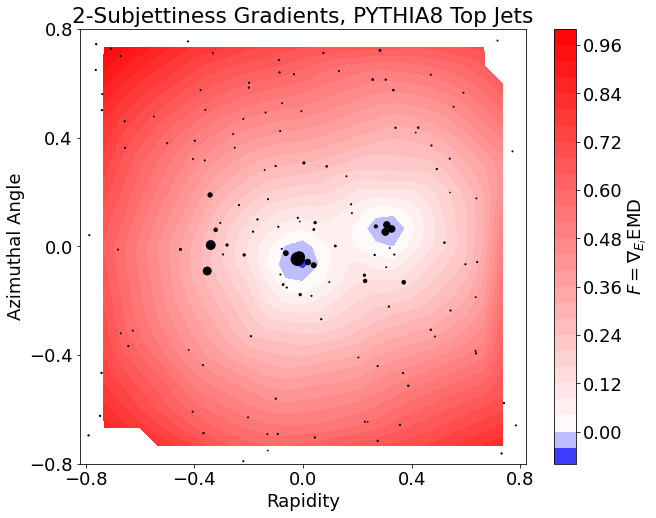

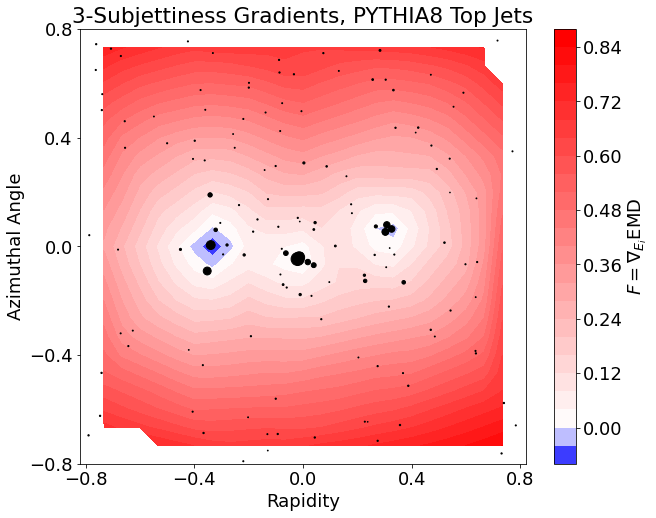

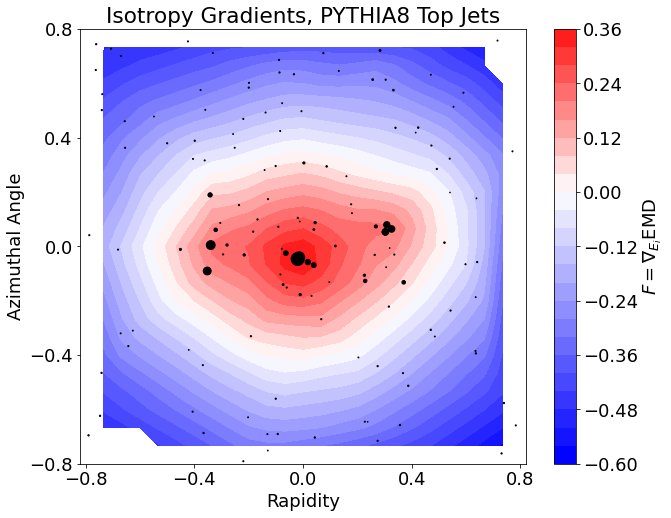

(145, 2)


NameError: name 'F' is not defined

In [16]:
from scipy.interpolate import griddata
import matplotlib.colors as colors


def grad_plot(obs):
    i = 0
    event = signal_pu[i]
    F = Fs[obs][i][:event[1].shape[0]]
    emd = signal_emds[obs][i]

    energy_uncertainty = 0.15 * event[1]
    var2 = np.sum(np.power(F,2) * np.power(energy_uncertainty,2))




    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'



    xi = np.linspace(-R, R, 25)
    yi = np.linspace(-R, R, 25)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((event[0][:,0],event[0][:,1]), F, (xi, yi),method='linear')

    # ax.scatter(event[0][:,0],event[0][:,1], color = "black", alpha = abs(F) / max(abs(F)))
    # plt.contourf(xi, yi, zi, 15, colors = "k", linewidths = 0.5)


    norm = colors.TwoSlopeNorm(vmin=min(F), vcenter=0, vmax=max(F))

    plt.contourf(xi, yi, zi, 25, cmap = plt.get_cmap("bwr"), norm = norm)


    ax.scatter(event[0][:,0],event[0][:,1], color = "black", s = 1000* event[1] /sum(event[1]))

    cbar = plt.colorbar() 
    cbar.set_label(r"$F = \nabla_{E_i}$EMD")
    # plt.scatter(x, y, marker = 'o', c = 'b', s = 10, zorder = 10)
    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.axis('equal')
    # plt.text(-0.5, 0.45, "EMD = %.e $\pm$ %.3e" % (emd, np.sqrt(var2)))
    # plt.text(-0.5, 0.40, "Assuming 10\% uncorrelated uncertainties")
    # plt.text(-0.5, 0.35, r"$\beta = $ %d" % beta)

    plt.xlabel('Rapidity')
    plt.ylabel('Azimuthal Angle')
    plt.title("%s Gradients, PYTHIA8 Top Jets" % obs)

    plt.xticks(np.linspace(-R, R, 5))
    plt.yticks(np.linspace(-R, R, 5))

    ax.set_aspect('equal')
    # plt.zlabel(r"$F = \nabla_z$EMD")

    plt.savefig("Plots/%s_Gradient.pdf" %obs)
    plt.show()
    plt.close()


def quiver_plot(obs):

    i = 0
    event = signal_pu[i]
    dx = dxs[obs][i][:event[1].shape[0]]
    emd = signal_emds[obs][i]

    print(dx.shape)

    energy_uncertainty = 0.15 * event[1]
    var2 = np.sum(np.power(F,2) * np.power(energy_uncertainty,2))




    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'



    xi = np.linspace(-R, R, 20)
    yi = np.linspace(-R, R, 20)
    xi, yi = np.meshgrid(xi, yi)
    dxi = griddata((event[0][:,0],event[0][:,1]), dx, (xi, yi),method='linear')
    dxi = np.nan_to_num(dxi)
    norm = np.sqrt(dxi[:,:,0]**2 + dxi[:,:,1]**2)
    dxi = dxi / np.sqrt(dxi[:,:,0]**2 + dxi[:,:,1]**2)[:,:,None]

    print(dxi.shape)
    print(norm.shape)
    print((norm / np.nanmax(np.abs(norm))).shape)

    ax.quiver(xi, yi, dxi[:,:,0], dxi[:,:,1], color = "red",  alpha = np.sqrt(norm / np.nanmax(np.abs(norm)),) , width = 0.01 )
    ax.scatter(event[0][:,0],event[0][:,1], color = "black", s = 1000* event[1] /sum(event[1]))

    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.axis('equal')
    # plt.text(-0.5, 0.45, "EMD = %.e $\pm$ %.3e" % (emd, np.sqrt(var2)))
    # plt.text(-0.5, 0.40, "Assuming 10\% uncorrelated uncertainties")
    # plt.text(-0.5, 0.35, r"$\beta = $ %d" % beta)

    plt.xlabel('Rapidity')
    plt.ylabel('Azimuthal Angle')
    plt.title("%s Gradients, PYTHIA8 Top Jets" % obs)

    plt.xticks(np.linspace(-R, R, 5))
    plt.yticks(np.linspace(-R, R, 5))

    ax.set_aspect('equal')
    # plt.zlabel(r"$F = \nabla_z$EMD")

    plt.savefig("Plots/%s_Quiver.pdf" % obs)
    plt.show()
    plt.close()

grad_plot("1-Subjettiness")
grad_plot("2-Subjettiness")
grad_plot("3-Subjettiness")
grad_plot("Isotropy")


quiver_plot("1-Subjettiness")
quiver_plot("2-Subjettiness")
quiver_plot("3-Subjettiness")
quiver_plot("Isotropy")

# print(F.shape)
# N = int(np.sqrt(len(F)))
# F = F.view(N, N)
# F = np.nan_to_num(F)

# # And display it with contour lines:
# # levels = np.linspace(-1, 1, nlines)
# ax.contourf(
#     F,
#     origin="lower",
#     linewidths=2.0,
#     colors="jet",
# )

In [ ]:
plt.hist(signal_emds["2-Subjettiness"] / signal_emds["1-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["2-Subjettiness"] / background_emds["1-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()
plt.show()

plt.hist(signal_emds["3-Subjettiness"] / signal_emds["2-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["3-Subjettiness"] / background_emds["2-Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()

In [ ]:
import scipy.stats as stats


uncertainy = .15
zis = np.random.normal(loc=1.0, scale= uncertainy, size=(250, event[1].shape[0]))


uncertain_events = []
for i in range(250):

    e = (event[0], (zis[i] * event[1]) / np.sum(zis[i] * event[1]))
    uncertain_events.append(e)

uncertain_emds, uncertain_params = shaper.calculate(uncertain_events, epochs = 500, verbose=True, lr = 0.01, scaling = 0.9, epsilon = 0.001, early_stopping= 25, N = 500, return_grads=False)

bins = 10
lims = [0.030, 0.036]
binwidth = (lims[1]-lims[0]) / bins
x = np.linspace(lims[0], lims[1], 100)
plt.plot(x, stats.norm.pdf(x, emd, np.sqrt(var2)) , label = "Gradient Prop")
plt.hist(uncertain_emds["Isotropy_16"], bins = bins, label = "Resampling", density = True)
plt.axvline(emd, color = "red", label = "Event EMD")
plt.title("Poor Man's Unfolding - Single Event ")
plt.xlabel("EMD")
plt.legend()

# Benchmarks - Apollonius

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
rhos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
observables = {"MAX Subjettiness": _MAXsubjettiness}
for rho in rhos:
    _apollonius = (_MAXsubjettiness + _isotropy)
    _apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))
    observables["Apollonius %d" % (rho * 10)] = _apollonius
observables["Isotropy"] = _isotropy

shaper = Shaper(observables)

# print(signal[0][1])
cms_emds, _ = shaper.calculate(cms, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_emds, _ = shaper.calculate(sim, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)
_ = 0

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

# print(signal_emds, background_emds)

for (i, rho) in enumerate(rhos):
    sg_ys.append(np.mean(cms_emds["Apollonius %d" %i]))
    sg_errs.append(np.std(cms_emds["Apollonius %d" %i]))
    bg_ys.append(np.mean(sim_emds["Apollonius %d" %i]))
    bg_errs.append(np.std(sim_emds["Apollonius %d" %i]))

plt.errorbar(np.array(rhos) + 0.01, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(rhos, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
plt.axhline(np.mean(cms_emds["Isotropy"]), color = "red", linestyle = "--")
plt.axhline(np.mean(sim_emds["Isotropy"]), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "CMS Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "SIM Jets"),
                 Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),]
plt.legend(handles = custom_legend)
plt.xlabel(r"$\rho$")
plt.ylabel("EMD")
plt.title("Apollonius EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [.2, 1.0]
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_emds[obs] / np.max(cms_emds[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_emds[obs] / np.max(sim_emds[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



plot_hist("Apollonius 2", "red", r"$\rho = 0.2$")
plot_hist("Isotropy", "blue", "Isotropy")
# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'Apollonius EMD / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()


In [ ]:
# How far is each event from its (normalized) corrected event?

for rho in rhos:
    observables["Apollonius %d" % (rho * 10)].freeze("Weights")
    observables["Apollonius %d" % (rho * 10)].freeze("Joint Weights")

# Benchmarks - Nsubjettiness

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
N = np.arange(1,126)
observables = {}
for n in N:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

shaper = Shaper(observables)

# print(signal[0][1])
cms_njettiness, _ = shaper.calculate(cms, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
sim_njettiness, _ = shaper.calculate(sim, epochs = 25, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'



cms_njettiness["0-Subjettiness"] = np.zeros_like(cms_njettiness["1-Subjettiness"])
sim_njettiness["0-Subjettiness"] = np.zeros_like(sim_njettiness["1-Subjettiness"])

# print(signal_emds, background_emds)

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

for n in N:
    sg_ys.append(np.mean(np.nan_to_num(cms_njettiness["%d-Subjettiness" % n] / cms_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    sg_errs.append(np.std(cms_njettiness["%d-Subjettiness" % n]/ cms_njettiness["%d-Subjettiness" % (n-1)])*0)
    bg_ys.append(np.mean(np.nan_to_num(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)], 1.0)))
    bg_errs.append(np.std(sim_njettiness["%d-Subjettiness" % n] / sim_njettiness["%d-Subjettiness" % (n-1)])*0)


print(len(sg_ys), N.shape)

plt.errorbar(N + 0.1, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(N, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# # plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
# plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
# plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                #  Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),
                 ]
plt.legend(handles = custom_legend)
plt.xlabel(r"$N$")
plt.ylabel("EMD")
# plt.yscale("log")
plt.ylim([0,1])
plt.title("N-Subjettiness EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
range = [0, 1]
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = '12'

def plot_hist(obs, color, label):

    bins = 25
    counts,bin_edges = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]),bins = bins, range = range, weights= cms_weights)
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_njettiness[obs] / np.max(cms_njettiness[obs]), bins=bins, weights=cms_weights*cms_weights)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    plt.errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    plt.hist(sim_njettiness[obs] / np.max(cms_njettiness[obs] ), bins = 25, weights = sim_weights * sim_factors, range = range, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)



# plot_hist("1-Subjettiness", "red", r"$N = 1$")
# plot_hist("2-Subjettiness", "orange", r"$N = 2$")
# plot_hist("3-Subjettiness", "yellow", r"$N = 3$")
# plot_hist("5-Subjettiness", "green", r"$N = 5$")
# plot_hist("10-Subjettiness", "blue", r"$N = 10$")
# plot_hist("25-Subjettiness", "purple", r"$N = 25$")
plot_hist("50-Subjettiness", "black", r"$N = 50$")

# plot_hist("Apollonius 6", "yellow")
# plot_hist("Apollonius 8", "green")
# plot_hist("Apollonius 10", "blue")


xlabel = r'N-Jettiness / Max'
ylabel = 'Differential Cross Section [nb]'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Apollonius Distributions')
plt.legend()